In [22]:
# H2O
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from venn import venn
from upsetplot import UpSet, from_contents
from IPython.display import display, HTML

In [5]:
moaks_df = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/kmri_sq_moaks_bicl_values.pkl', 'rb'))

In [15]:
tka_ids_dict = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/TKA_ids.pkl', 'rb'))
tka_df = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/TKA_PROs_df.pkl', 'rb'))

In [19]:
tka_ids_dict = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/TKA_ids.pkl', 'rb'))
tka_ids = tka_ids_dict['TKA']
condition_ids=set(tka_ids)
tka_ids = tka_ids_dict['TKA']
right_tka_ids = tka_ids_dict['TKA_Right']
left_tka_ids = tka_ids_dict['TKA_Left']

r_tka_df = tka_df.loc[tka_df.index.get_level_values(0).isin(right_tka_ids)]
l_tka_df = tka_df.loc[tka_df.index.get_level_values(0).isin(left_tka_ids)]
koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL']
              }


both_dict = dict()
lr_var_dict=koos_lr_subscale_dict
for metric_name, lr_var_names in lr_var_dict.items():
    both_df = pd.concat([r_tka_df[lr_var_names[0]], l_tka_df[lr_var_names[1]]])
    both_dict[metric_name] = both_df
both_df = pd.concat(both_dict, axis=1)

DF_list = list()
DF_list.append(both_df.loc[both_df.index.get_level_values(0).isin(condition_ids)])

In [20]:
AutoML_dataframe = pd.DataFrame(columns=['id','pain', 'inflam', 'cm', 'subc', 'atroph', 'hypertrop'])
data_list = DF_list[0]
my_list = []

for idx, data in data_list.groupby(level=0):
    if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
        two_post = data.loc[(idx, '2 post')]["Pain"]
        one_prior = data.loc[(idx, '1 prior')]["Pain"]
        result = two_post - one_prior
        if isinstance(result, np.float32):
            my_list.append(result)
            AutoML_dataframe.loc[idx, 'id'] = idx
            AutoML_dataframe.loc[idx, 'pain'] = result

/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_54702/1954696543.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_54702/1954696543.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  two_post = data.loc[(idx, '2 post')]["Pain"]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_54702/1954696543.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  one_prior = data.loc[(idx, '1 prior')]["Pain"]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_54702/1954696543.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_54702/1954696543.py:7: PerformanceWarning: indexing past lexsort depth may impact perfo

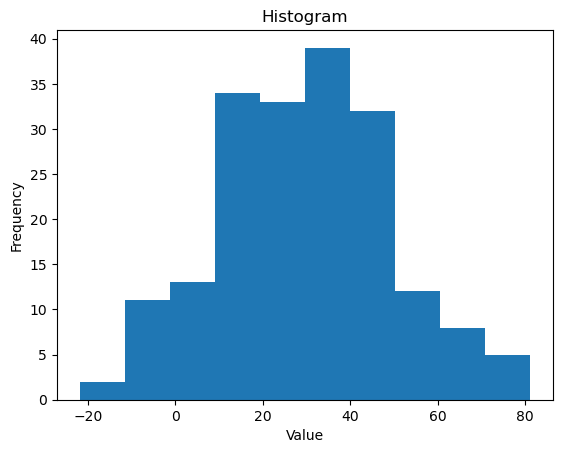

In [23]:
plt.hist(my_list)
# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show() 

## Inflammatory Phenotype: 
The inflammatory phenotype is characterized by synovial activation reflected on MRI by the surrogate markers of effusion-synovitis (defined by the amount of capsular distension) and Hoffa-synovitis (defined by the size of non-specific signal hyperintensity in Hoffa’s fat pad) with both being graded from 0 to 3. A maximum grade of 3 for either Hoffa- or effusion-synovitis and at least a grade 2 of the other respective inflammatory feature were required to fulfill the definition of an inflammatory phenotype (e.g., Hoffa-synovitis grade 3 required effusion-synovitis grade 2 or 3 and vice versa to fulfill the definition of this phenotype).

In OAI MOAKS data:

MSYIC - inter-condylar/Hoffa synovitis
MEFFWK - whole knee effusion

In [27]:
inflammatory_phenotype_moaks=set(moaks_df.query('MSYIC=="3: Severe" & (MEFFWK=="3: Severe" | MSYIC=="2: Moderate") | MEFFWK=="3: Severe" & (MSYIC=="3: Severe" | MSYIC=="2: Moderate")').index.get_level_values('ID').unique().values)
Inflammatory_Phenotype= (inflammatory_phenotype_moaks ) & tka_ids

## Cartilage Meniscal Phenotype
The cartilage/meniscal phenotype was defined by severe meniscal damage, including substance loss or maceration, which is commonly associated with severe cartilage loss. Criteria to be fulfilled were:

a meniscus score of at least a complex tear, partial meniscal maceration, or complete maceration in at least one subregion of the medial or lateral compartment
plus at least a tear of any type (including all types of maceration) in at least one subregion of the other compartment

Knees with posterior meniscal root tears were excluded. In addition, the presence of cartilage damage grades 2.1, 2.2, 3.2, or 3.3, according to MOAKS, in the more severely affected compartment.

In OAI MOAKS data, prefixes:

MMT - meniscal morphology
MCM - cartilage damage grades
MMRTL, MMRTM - posterior meniscal root tears

In [33]:
# First, throw away knees with posterior meniscal root tears (MMRTL or MMRTM) = "1:Yes" 
# (Knees with posterior meniscal root tears were excluded)
subset_df = moaks_df[moaks_df["MMRTL"] != "1: Yes"]
subset_df= subset_df[subset_df["MMRTM"] != "1:Yes"]
subset_df=subset_df.loc[:, subset_df.columns.str.startswith('MMT')| subset_df.columns.str.startswith("MCM")]
MMT_subset=subset_df[subset_df.isin(["3: Horizontal tear","6: Partial maceration","8: Complete maceration","2: Radial tear","4: Vertical tear","7: Progressive partial maceration"]).any(axis=1)]
#TODO:: In addition, the presence of cartilage damage grades 2.1, 2.2, 3.2, or 3.3, according to MOAKS, in the more severely affected compartment.

cartilage_meniscus_phenotype=set(MMT_subset.index.get_level_values('ID').unique().values)
Cartilage_Meniscus_Phenotype= (cartilage_meniscus_phenotype ) & tka_ids

## Atrophic Phenotype
Atrophic phenotype
The atrophic phenotype is characterized by marked cartilage damage without or with only little osteophyte formation and was defined as:

a maximum MOAKS osteophyte ≤1 in any location of the tibio-femoral joint (TFJ)
AND at least a grade 2.2 cartilage lesion in at least one of both TFJ compartments (defined as 10-75% of subregional cartilage surface area and full thickness involvement of 10-75% of subregional cartilage surface area)
Osteophytes are graded from 0 to 3 in MOAKS.

In OAI MOAKS data, prefixes:

MOS - osteophyte size
MCM - cartilage lesion

In [48]:
MOS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MOS') |moaks_df.columns.str.startswith('MCM') ]
MOS_subset=MOS_subset.drop(columns=['MCMPL','MCMPM']) #don't care about patella for this phenotype
## Throw out any knees with MOAKS osteophyte >1 (2 severe, 3 moderate)
boolean=MOS_subset.isin(['2: Moderate','3: Severe'])
boolean=~boolean 
MOS_subset=MOS_subset[boolean.any(axis=1)]
## Only keep knees with at least a grade 2.2 cartilage lesion in at least one of both TFJ compartments
boolean=MOS_subset.isin(['2.2: 10-75% area, 10-75% full thickness','3.3: >75% area, >75% full thickness','3: >75% area, no full thickness'])
MOS_subset=MOS_subset[boolean.any(axis=1)]
atrophic_phenotype=set(MOS_subset.index.get_level_values('ID').unique().values)
Atrophic_Phenotype= (atrophic_phenotype ) & tka_ids

## Subchondral bone phenotype
The subchondral bone phenotype was defined by a bone marrow lesion (BML) size of grade 3 in at least one subregion of 10 tibio-femoral subregions plus a grade 2 or grade 3 BML in an additional 2 subregions of 10 tibio-femoral subregions. BMLs in MOAKS are graded from 0 to 3.

In OAI MOAKS data, prefixes:

MBMS - BML lesion size

In [43]:
MBMS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MBMS')]
subchondral_bone_phenotype=MBMS_subset[MBMS_subset.isin(["3: > 66% of region"]).any(axis=1)]
#set(MBMS_subset[MBMS_subset.isin(["3: > 66% of region"]).any(axis=1)].index.get_level_values('ID').unique().values)
subchondral_bone_phenotype= subchondral_bone_phenotype[((subchondral_bone_phenotype == ("2: 33%-66% of region")) | (subchondral_bone_phenotype == ("3: > 66% of region"))).sum(axis=1) >= 3]
subchondral_bone_phenotype=set(subchondral_bone_phenotype.index.get_level_values('ID').unique().values)
Subchondral_Bone_Phenotype= (subchondral_bone_phenotype ) & tka_ids

## Hypertrophic Phenotype
Hypertrophic phenotype
The hypertrophic phenotype is characterized by large osteophytes and only little cartilage damage.

Knees having an osteophyte score of 3 in any location of the tibio-femoral joint
OR in the anterior medial or anterior lateral femur
AND cartilage damage of not more than a grade 1.1 in the same medial and lateral compartment fulfilled the definition.
The anterior femur was included in the definition as the hypertrophic phenotype is exceedingly rare. The definitions for atrophic and hypertrophic were adapted from previous work using MRI WORMS assessment for definition of these phenotypes[2].

In OAI MOAKS data, prefixes:

MOS - osteophyte size
MCM - cartilage lesion

In [49]:
MOS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MOS') |moaks_df.columns.str.startswith('MCM') ]
MOS_subset=MOS_subset.drop(columns=['MCMPL','MCMPM']) #don't care about patella for this phenotype
### Keep knees with osteophyte score of 3 in any location in TFJ
boolean=MOS_subset.isin(['3: Severe'])
MOS_subset=MOS_subset[boolean.any(axis=1)]
### TODO: For every column, find the spot where it was 3:severe and then check the corresponding cartilage column
hypertrophic_phenotype=set(MOS_subset.index.get_level_values('ID').unique().values)
Hypertrophic_Phenotype= hypertrophic_phenotype & tka_ids

In [56]:
AutoML_dataframe['inflam'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Inflammatory_Phenotype else 0)
AutoML_dataframe['cm'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Cartilage_Meniscus_Phenotype else 0)
AutoML_dataframe['subc'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Subchondral_Bone_Phenotype else 0)
AutoML_dataframe['atroph'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Atrophic_Phenotype else 0)
AutoML_dataframe['hypertrop'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Hypertrophic_Phenotype else 0)
AutoML_dataframe
AutoML_dataframe.drop(columns=['id'])
AutoML_dataframe.to_csv('AutoML_dataframe.csv',index=True)

In [57]:
AutoML_dataframe

,id,pain,inflam,cm,subc,atroph,hypertrop
9005132,9005132,31.25,0,1,1,1,0
9011918,9011918,22.222221,0,1,0,1,0
9014883,9014883,11.111115,0,1,0,1,0
9015363,9015363,55.555557,0,1,1,1,0
9027422,9027422,19.44445,0,1,0,1,0
...,...,...,...,...,...,...,...
9976720,9976720,44.444443,0,1,0,1,0
9988891,9988891,44.444443,0,1,1,1,0
9991313,9991313,33.333336,0,1,1,1,0
9992318,9992318,25.0,0,0,0,0,0


In [58]:
# Start the H2O cluster (locally)
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,11 hours 53 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_franceskoback_r9tncx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.149 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [59]:
AutoML_dataframe = pd.read_csv ('AutoML_dataframe.csv')
AutoML_dataframe.shape
train=AutoML_dataframe.head(152)
test=AutoML_dataframe.tail(37)

In [62]:
# Convert train, a Pandas dataframe into an H2O dataframe
train = h2o.H2OFrame(train)
col_types = train.types
# Do the same for test but use the column types from the first one to ensure they match 
#test = h2o.H2OFrame(test, column_types=col_types)

max_runtime_secs=100

# Create an automl object
# Allows for GBM and XGBoost models, and will keep creating models until max_runtime_sec or 20 models have been created
aml = H2OAutoML(include_algos = ["GBM", "XGBoost"], max_runtime_secs=max_runtime_secs, max_models=20, seed=42)

# All columns other than the label column are features used for training
x = train.columns
y = 'pain'
x.remove(y)

# x is a list of feature column names, y is the name of the label column, train is the H2OFrame with the actual data
aml.train(x=x, y='pain', training_frame=train)


21:30:38.483: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 152.0.



Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_2_20230531_213037_model_6


Model Summary: 
    number_of_trees
--  -----------------
    36

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 387.9017159350523
RMSE: 19.695220636871586
MAE: 15.781058298914056
RMSLE: NaN
Mean Residual Deviance: 387.9017159350523

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 439.145576571879
RMSE: 20.95580054714873
MAE: 16.77621797511452
RMSLE: NaN
Mean Residual Deviance: 439.145576571879

Cross-Validation Metrics Summary: 
                        mean        sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  --------  ------------  ------------  ------------  ------------  ------------
mae                     16.7747     1.35989   17.7769       15.9993       17.0678       18.1837       14.8459
mean_residual_deviance  439.025     74.3583   515.904       380.431       464.193       492.117       342.481
mse                     439.025     74.3583   515.904       380.431       464.193       492.117       342.481
r2                      -0.0965409  0.137108  -0.0470627    -0.149668     -0.311041     0.0048061     0.0202606
residual_deviance       439.025     74.3583   515.904       380.431       464.193       492.117       342.481
rmse                    20.8907     1.80483   22.7135       19.5046       21.5451       22.1837       18.5062
rmsle                   nan         0         nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-05-31 21:30:40  0.765 sec   0                  34.5194          29.3191         1191.59
    2023-05-31 21:30:40  0.771 sec   5                  23.1534          18.2172         536.078
    2023-05-31 21:30:40  0.772 sec   10                 20.95            16.786          438.903
    2023-05-31 21:30:40  0.773 sec   15                 20.4305          16.3973         417.405
    2023-05-31 21:30:40  0.775 sec   20                 20.1522          16.2113         406.113
    2023-05-31 21:30:40  0.776 sec   25                 20.0159          16.1027         400.635
    2023-05-31 21:30:40  0.778 sec   30                 19.8321          15.8981         393.311
    2023-05-31 21:30:40  0.779 sec   35                 19.7453          15.8412         389.878
    2023-05-31 21:30:40  0.783 sec   36                 19.6952          15.7811         387.902

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
Unnamed: 0  4489.84                1                    0.49643
id          2295.57                0.511282             0.253816
subc        1639.68                0.365198             0.181295
atroph      420.292                0.0936097            0.0464707
cm          198.866                0.0442926            0.0219882

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

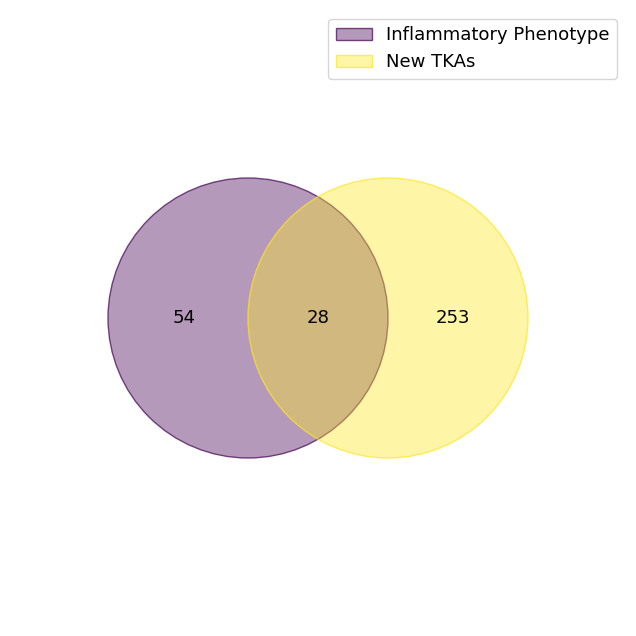

In [26]:
patients = {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'New TKAs': tka_ids
}
plot = venn(patients)

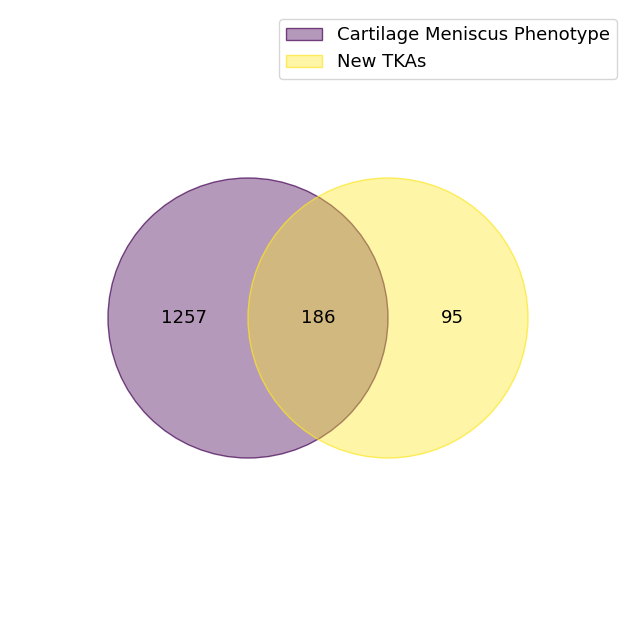

In [32]:
patients_cmp= {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_cmp)

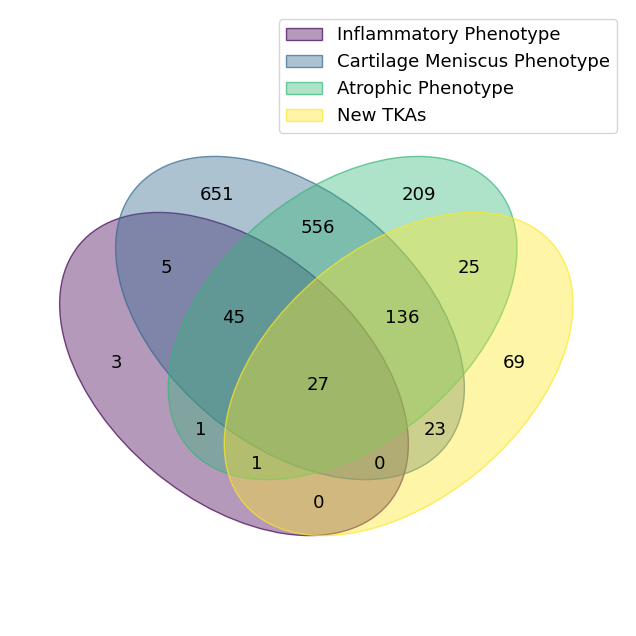

In [38]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'Atrophic Phenotype':atrophic_phenotype, 
    'New TKAs': tka_ids
}
plot = venn(patients_total)

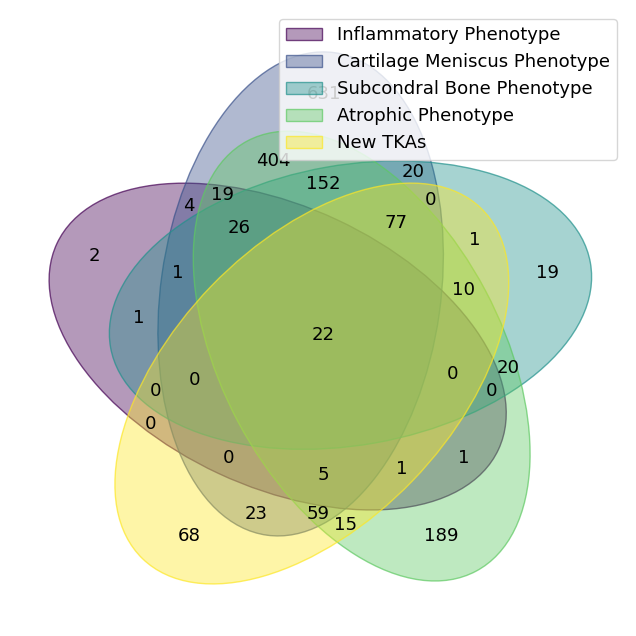

In [44]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'Subcondral Bone Phenotype': subchondral_bone_phenotype,
    'Atrophic Phenotype':atrophic_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_total)

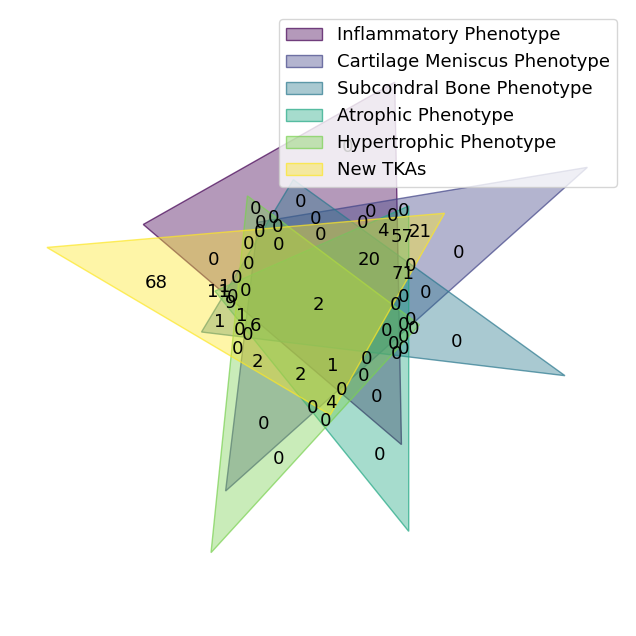

In [51]:
patients= {
    'Inflammatory Phenotype': Inflammatory_Phenotype,
    'Cartilage Meniscus Phenotype': Cartilage_Meniscus_Phenotype,
    'Subcondral Bone Phenotype': Subchondral_Bone_Phenotype,
    'Atrophic Phenotype':Atrophic_Phenotype,
    'Hypertrophic Phenotype': Hypertrophic_Phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients)

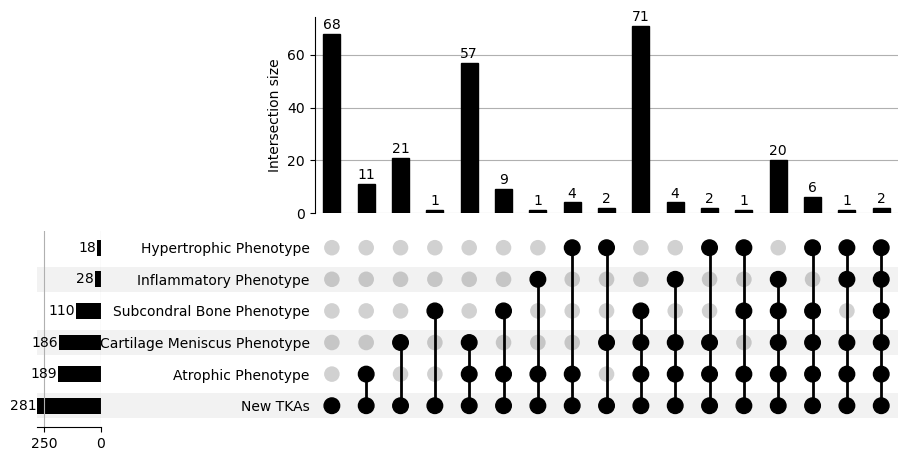

In [52]:
#patients_total
plot = UpSet(from_contents(patients), show_counts=True).plot()
plt.savefig("OAI_upset_graph.svg")

##### TODO: how is it possible for someone to be in hypertrophic and atrophicp phenotype? check this
I think this is when there isn't enough data? Double check

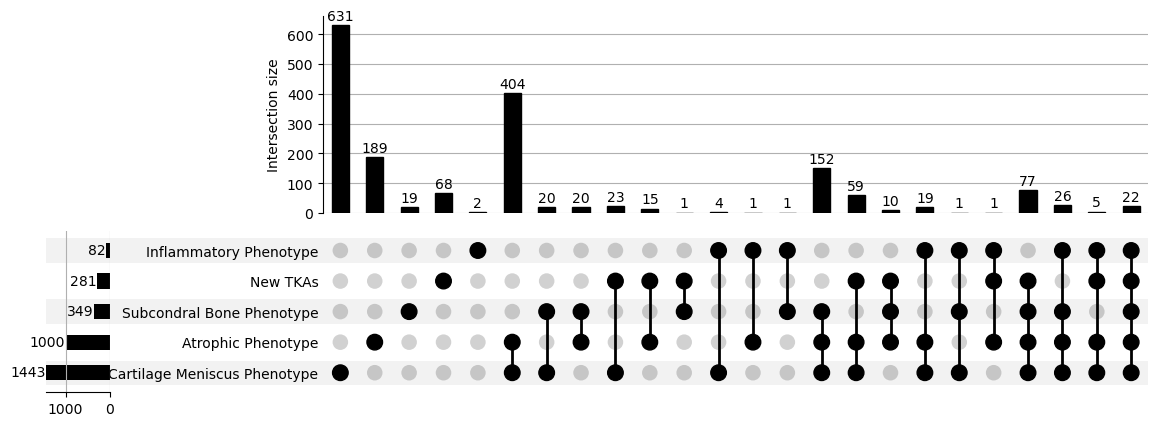

In [53]:
#patients_total
plot = UpSet(from_contents(patients_total), show_counts=True).plot()
plt.savefig("OAI_upset_graph.svg")